In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/project/bioe486_final_project-main/code')

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 587.3 kB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-n8befmh1
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-n8befmh1
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=48badaab99340fed50749bc94f1e5c52125ace171d15a24d4d13f8a2d9bb3497
  Stored in directory: /tmp/pip-ephem-wheel-cache-0gubamcf/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
from PIL import Image
from torch.utils.data import Dataset
from torchvision.io import read_image
import clip
import os
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import clip
import math
import pandas as pd

class CTDataset(Dataset):
    def __init__(self, csv, preprocess, data_dir = "/content/drive/MyDrive/project/val_data/"):
        self.data_dir = data_dir
        self.preprocess = preprocess
        self.img_paths = csv["image_path"].values
        self.labels = csv["image_label"].values
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.img_paths[idx])
        image = self.preprocess(Image.open(img_path))
        img_label = self.labels[idx]
        return image, img_label

In [ ]:
#Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
#load model try
model_fine = torch.load("/content/drive/MyDrive/project/bioe486_final_project-main/code/best_model.pth", map_location=device)
model, preprocess = clip.load("ViT-B/32", device=device)
tokenizer = clip.simple_tokenizer.SimpleTokenizer()

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 60.2MiB/s]


In [ ]:
# collect image
path_t = "/content/drive/MyDrive/project/bioe486_final_project-main/data/"
ct_csv = pd.read_csv(path_t + "CT_data.csv")
BATCH_SIZE = 1
ct_ds = CTDataset(ct_csv, preprocess)
# image_save, label_save = ct_ds.__getitem__(0)
# print(image_save.shape)
ct_dataloader = DataLoader(ct_ds, batch_size = BATCH_SIZE, shuffle=True)
# image_save = np.empty((0,3,224,224))
# label_save = np.empty(0)
# record_tmp = np.array([0,0,0])
for idx, (images, labels) in enumerate(ct_dataloader):
  if idx==0:
    image_save = images
    label_save = labels
    break

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
import warnings
warnings.filterwarnings('ignore')

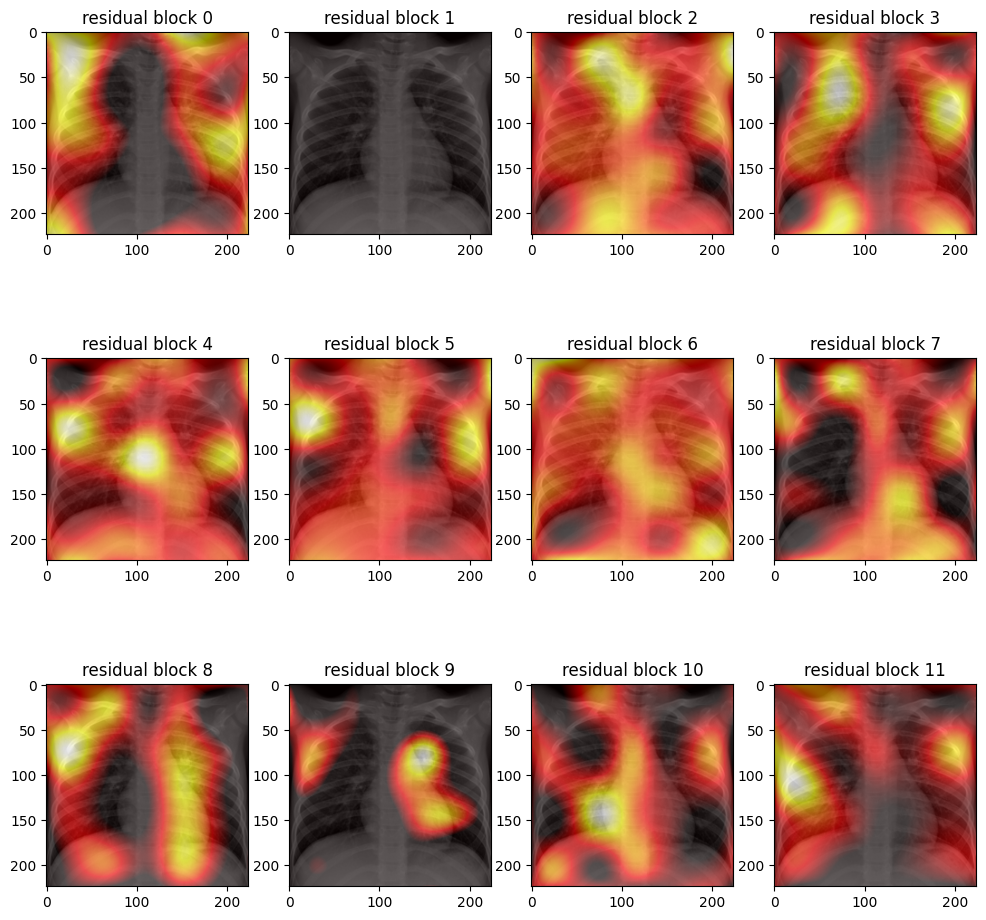

In [ ]:
# print(model.visual.transformer.resblocks[0].attn)
# pp = model.visual.transformer.resblocks[0]
# attn_0 = model.visual.transformer.resblocks[0].attn
plt.figure(figsize=(12,12))
for i in range(12):
  x = image_save.type(torch.HalfTensor).to(device)
  x = model.visual.conv1(x)
  x = x.reshape(x.shape[0], x.shape[1], -1)
  x = x.permute(0, 2, 1) 
  x = torch.cat([model.visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)
  x = x + model.visual.positional_embedding.to(x.dtype)
  x = model.visual.ln_pre(x)
  x = x.permute(1, 0, 2) 
  x = model.visual.transformer.resblocks[i].ln_1(x)
  att_mat = model.visual.transformer.resblocks[i].attn(x, x, x, need_weights=True, attn_mask=None)[1]
  att_mat = att_mat.squeeze(0)

  # To account for residual connections, we add an identity matrix to the
  # attention matrix and re-normalize the weights.
  residual_att = torch.eye(att_mat.size(1)).type(torch.HalfTensor).to(device)
  aug_att_mat = att_mat + residual_att
  aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

  # Recursively multiply the weight matrices
  joint_attentions = torch.zeros(aug_att_mat.size()).type(torch.HalfTensor).to(device)
  joint_attentions[0] = aug_att_mat[0]

  for n in range(1, aug_att_mat.size(0)):
      joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
  # plt.imshow(joint_attentions.detach().cpu().numpy())

  # Attention from the output token to the input space.
  v = joint_attentions[0,1:]
  # print(v.shape)
  grid_size = int(np.sqrt(aug_att_mat.size(-1)))
  # print(grid_size)
  mask = v.reshape(grid_size, grid_size).detach().cpu().numpy()
  # plt.imshow(mask)

  # project mask to image
  # print(mask.shape)
  image_save_numpy = image_save.squeeze()
  # print(image_save_numpy.shape)
  f = interpolate.interp2d(np.linspace(0,1,7),np.linspace(0,1,7),mask,'cubic')
  newmask = f(np.linspace(0,1,224),np.linspace(0,1,224))
  newmask[newmask<4e-3] = 4e-3
  masked_image = image_save_numpy[0,:,:]
  ax=plt.subplot(3,4,i+1)
  plt.imshow(masked_image,cmap='gray')
  plt.imshow(newmask,alpha=.6,cmap='hot')
  ax.set_title('residual block {}'.format(i))

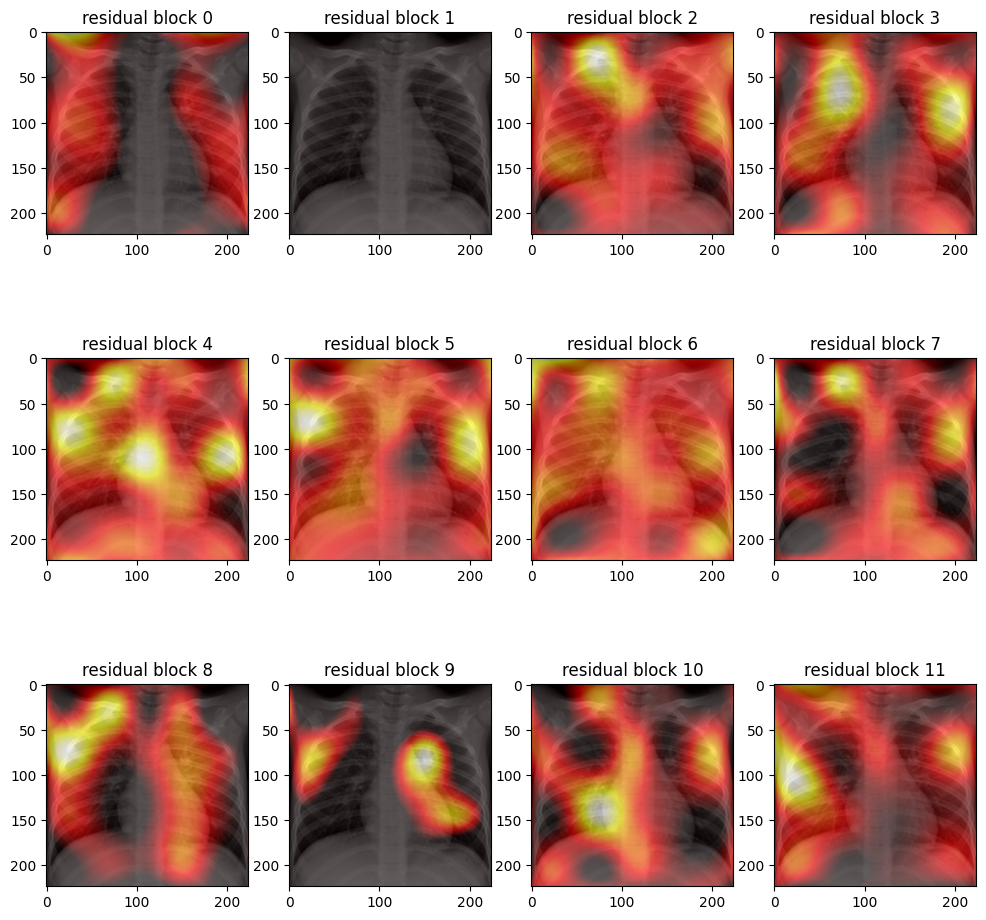

In [ ]:
plt.figure(figsize=(12,12))
for i in range(12):
  x = image_save.type(torch.HalfTensor).to(device)
  x = model_fine.visual.conv1(x)
  x = x.reshape(x.shape[0], x.shape[1], -1)
  x = x.permute(0, 2, 1) 
  x = torch.cat([model_fine.visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)
  x = x + model_fine.visual.positional_embedding.to(x.dtype)
  x = model_fine.visual.ln_pre(x)
  x = x.permute(1, 0, 2) 
  x = model_fine.visual.transformer.resblocks[i].ln_1(x)
  att_mat = model_fine.visual.transformer.resblocks[i].attn(x, x, x, need_weights=True, attn_mask=None)[1]
  att_mat = att_mat.squeeze(0)

  # To account for residual connections, we add an identity matrix to the
  # attention matrix and re-normalize the weights.
  residual_att = torch.eye(att_mat.size(1)).type(torch.HalfTensor).to(device)
  aug_att_mat = att_mat + residual_att
  aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

  # Recursively multiply the weight matrices
  joint_attentions = torch.zeros(aug_att_mat.size()).type(torch.HalfTensor).to(device)
  joint_attentions[0] = aug_att_mat[0]

  for n in range(1, aug_att_mat.size(0)):
      joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
  # plt.imshow(joint_attentions.detach().cpu().numpy())

  # Attention from the output token to the input space.
  v = joint_attentions[0,1:]
  # print(v.shape)
  grid_size = int(np.sqrt(aug_att_mat.size(-1)))
  # print(grid_size)
  mask = v.reshape(grid_size, grid_size).detach().cpu().numpy()
  # plt.imshow(mask)

  # project mask to image
  # print(mask.shape)
  image_save_numpy = image_save.squeeze()
  # print(image_save_numpy.shape)
  f = interpolate.interp2d(np.linspace(0,1,7),np.linspace(0,1,7),mask,'cubic')
  newmask = f(np.linspace(0,1,224),np.linspace(0,1,224))
  newmask[newmask<4e-3] = 4e-3
  masked_image = image_save_numpy[0,:,:]
  ax=plt.subplot(3,4,i+1)
  plt.imshow(masked_image,cmap='gray')
  plt.imshow(newmask,alpha=.6,cmap='hot')
  ax.set_title('residual block {}'.format(i))